In [1]:
LM = readRDS("/hps/nobackup/stegle/users/acuomo/all_scripts/sc_neuroseq/in_vivo_comparison/sce_lamanno_embryo.Rds")

In [40]:
LM

class: SingleCellExperiment 
dim: 19531 136 
metadata(0):
assays(2): counts logcounts
rownames(19531): DDX11L1 WASH7P_p1 ... VAMP7_loc1 DDX11L16_loc1
rowData names(0):
colnames(136): 1772067_089_B06 1772071_027_C04 ... 1772122_223_D12
  1772122_224_F04
colData names(3): Cell_ID Cell_type Timepoint
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [3]:
LM$Cell_type = as.character(LM$Cell_type)
unique(LM$Cell_type)

[1] "hMgl"     "hRgl2a"   "Unk"      "hNProg"   "hProgBP"  "hProgM"  
 [7] "hOMTN"    "hDA0"     "hNbM"     "hProgFPL" "hEndo"    "hProgFPM"
[13] "hRgl2b"   "hNbML5"   "hRgl3"    "hRN"      "hPeric"   "hDA1"    
[19] "hRgl1"    "hGaba"    "hDA2"     "hSert"    "hNbGaba"  "hNbML1"  
[25] "hRgl2c"   "hOPC"

In [4]:
LM = LM[,LM$Cell_type %in% c('hDA0','hDA1','hDA2','hSert')]

In [5]:
LM <- scater::logNormCounts(LM, log=T)
alt.fit2 <- scran::trendVar(LM, use.spikes = FALSE)
alt.decomp2 <- scran::decomposeVar(LM, alt.fit2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'testVar' is deprecated.
See help("Deprecated")”

In [6]:
genes_LM = rownames(alt.decomp2[order(alt.decomp2$bio, decreasing = TRUE),][1:2000,])

In [8]:
mydir = "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_neuroseq/in_vivo_comparison/"

In [9]:
SN_filename = paste0(mydir,"snigra_sce.RDS")
SN = readRDS(SN_filename)

In [10]:
SN = SN[,grep("NEURO",SN$clusters)]
SN

class: SingleCellExperiment 
dim: 29445 2028 
metadata(0):
assays(1): counts
rownames(29445): A1BG A1BG-AS1 ... bP-2171C21.3 bP-2189O9.3
rowData names(0):
colnames(2028): Miami6060a_CAGTCCTAGCGCTTAT-1
  Miami6060a_GCACTCTCATGTAAGA-1 ... MD5862c_CCATGTCGTTCGGCAC-1
  MD5862c_CACACAACATACGCCG-1
colData names(6): nUMI nGene ... tsne1 tsne2
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [11]:
SN <- scater::logNormCounts(SN, log=T)
design <- model.matrix(~dataset, data = colData(SN))
alt.fit2 <- scran::trendVar(SN, design = design, use.spikes = FALSE)
alt.decomp2 <- scran::decomposeVar(SN, alt.fit2)

Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'testVar' is deprecated.
See help("Deprecated")”

In [13]:
# genes_SN = rownames(SN)
genes_SN = rownames(alt.decomp2[order(alt.decomp2$bio, decreasing = TRUE),][1:2000,])

In [14]:
all_genes = unique(c(genes_LM,genes_SN))

In [15]:
genes_n = rownames(SN)[rownames(SN) %in% all_genes]
common_genes = rownames(LM)[rownames(LM) %in% genes_n]

In [16]:
query = LM[common_genes,]
reference = SN[common_genes,]

In [17]:
query$batch_factor = "query"
reference$batch_factor = "reference"

In [18]:
getJointPCA = function(reference, query, 
                       assayNameRef = "logcounts",
                       assayNameQuery = "logcounts") {
# reference and query are SingleCellExperiment objects
  all_assay = cbind(assay(query, assayNameQuery),
                    assay(reference, assayNameRef))
# batch factors can be dataset specific batches or just a factor labelling i.e. "query", "reference" 
#   batchFactor = factor(c(as.character(query$sample_id),
#                            as.character(reference$dataset)))
 batchFactor = factor(c(as.character(query$batch_factor),
                           as.character(reference$batch_factor)))
#   print(table(batchFactor))
  mbpca = batchelor::multiBatchPCA(all_assay,
                        batch = batchFactor,
                        d = 50
                        # BPPARAM = BiocParallel::MulticoreParam(workers = 4)
  )
  print("done multibatch PCA")
  dim(mbpca[[1]])
  out = do.call(batchelor::reducedMNN, mbpca)
  print("done batch correction")
  joint_mnn_pca = out$corrected
  return(joint_mnn_pca)
}

In [19]:
joint_mnn_pca = getJointPCA(reference, query)

Warning message in sweep(centered, 2, w, "/", check.margin = FALSE):
“'check.margin' is ignored when 'x' is a DelayedArray object or
  derivative”

[1] "done multibatch PCA"
[1] "done batch correction"


In [20]:
df_pca = as.data.frame(joint_mnn_pca[,c(1:2)])
colnames(df_pca) = paste0("PC",1:2)
head(df_pca)

,PC1,PC2
1772067_089_B06,15.307301,-3.7423396
1772071_027_C04,3.598099,18.5090544
1772071_027_E03,15.671637,0.9584330
1772071_029_B10,15.304477,-0.8788388
1772071_029_B12,16.300775,-2.3173524
1772071_029_C11,14.644128,1.8049492


In [28]:
mat = matrix(0, nrow = length(unique(query$Cell_type)), ncol = length(unique(reference$clusters)))
nrow(mat)
ncol(mat)

[1] 4

[1] 7

In [34]:
rownames(mat) = unique(query$Cell_type)
colnames(mat) = unique(reference$clusters)

In [35]:
i = 0
for (celltype in unique(query$Cell_type)){
#     print(celltype)
    j = 0
    i = i+1
    sel_cells = colnames(query[,query$Cell_type == celltype])
    closest_atlas_cell_ind = BiocNeighbors::queryKNN(
        joint_mnn_pca[colnames(reference),],
        joint_mnn_pca[sel_cells,],
        k = 1, get.index = TRUE, get.distance = FALSE)
    mapped_cells = colnames(reference)[closest_atlas_cell_ind$index]
    for (cluster in unique(reference$clusters)){
#         print(cluster)
        j = j+1
        n = length(mapped_cells[mapped_cells %in% colnames(reference[,reference$clusters == cluster])])
        mat[i,j] = n/length(mapped_cells)
#         print(mat[i,j])
    }
}

In [36]:
mat

,NEUROinh4,NEUROinh2,NEUROinh3,NEUROdop,NEUROinh5,NEUROinh1,NEUROex1
hDA0,0.04255319,0,0.04255319,0.06382979,0.00000000,0.7872340,0.06382979
hDA1,0.05263158,0,0.02631579,0.15789474,0.05263158,0.6315789,0.07894737
hDA2,0.00000000,0,0.00000000,0.29729730,0.00000000,0.7027027,0.00000000
hSert,0.00000000,0,0.07142857,0.07142857,0.00000000,0.7857143,0.07142857


In [37]:
library(reshape2)
mat_melt = melt(mat)
head(mat_melt)

Var1,Var2,value
hDA0,NEUROinh4,0.04255319
hDA1,NEUROinh4,0.05263158
hDA2,NEUROinh4,0.00000000
hSert,NEUROinh4,0.00000000
hDA0,NEUROinh2,0.00000000
hDA1,NEUROinh2,0.00000000


In [38]:
library(ggplot2)

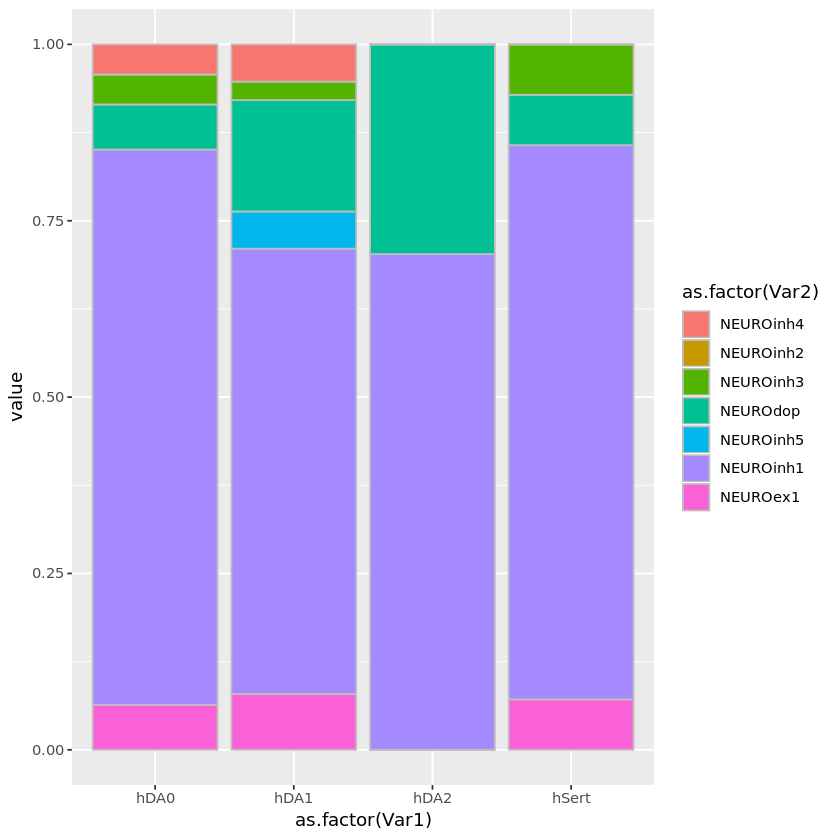

In [39]:
df = as.data.frame(mat_melt)
ggplot(df, aes(x = as.factor(Var1), y = value, fill = as.factor(Var2))) + geom_bar(stat="identity", col = "grey")

In [41]:
mat = matrix(0, ncol = length(unique(query$Cell_type)), nrow = length(unique(reference$clusters)))
nrow(mat)
ncol(mat)

[1] 7

[1] 4

In [42]:
colnames(mat) = unique(query$Cell_type)
rownames(mat) = unique(reference$clusters)

In [43]:
i = 0
for (celltype in unique(reference$clusters)){
#     print(celltype)
    j = 0
    i = i+1
    sel_cells = colnames(reference[,reference$clusters == celltype])
    closest_atlas_cell_ind = BiocNeighbors::queryKNN(
        joint_mnn_pca[colnames(query),],
        joint_mnn_pca[sel_cells,],
        k = 1, get.index = TRUE, get.distance = FALSE)
    mapped_cells = colnames(query)[closest_atlas_cell_ind$index]
    for (cluster in unique(query$Cell_type)){
#         print(cluster)
        j = j+1
        n = length(mapped_cells[mapped_cells %in% colnames(query[,query$Cell_type == cluster])])
        mat[i,j] = n/length(mapped_cells)
#         print(mat[i,j])
    }
}

In [44]:
mat

,hDA0,hDA1,hDA2,hSert
NEUROinh4,0.014234875,0.9003559,0.0000000,0.085409253
NEUROinh2,0.002409639,0.9927711,0.0000000,0.004819277
NEUROinh3,0.066901408,0.8485915,0.0000000,0.084507042
NEUROdop,0.009090909,0.5545455,0.4272727,0.009090909
NEUROinh5,0.066666667,0.8380952,0.0000000,0.095238095
NEUROinh1,0.097053726,0.7400347,0.1126516,0.050259965
NEUROex1,0.000000000,0.9271523,0.0000000,0.072847682


In [45]:
library(reshape2)
mat_melt = melt(mat)
head(mat_melt)

Var1,Var2,value
NEUROinh4,hDA0,0.014234875
NEUROinh2,hDA0,0.002409639
NEUROinh3,hDA0,0.066901408
NEUROdop,hDA0,0.009090909
NEUROinh5,hDA0,0.066666667
NEUROinh1,hDA0,0.097053726


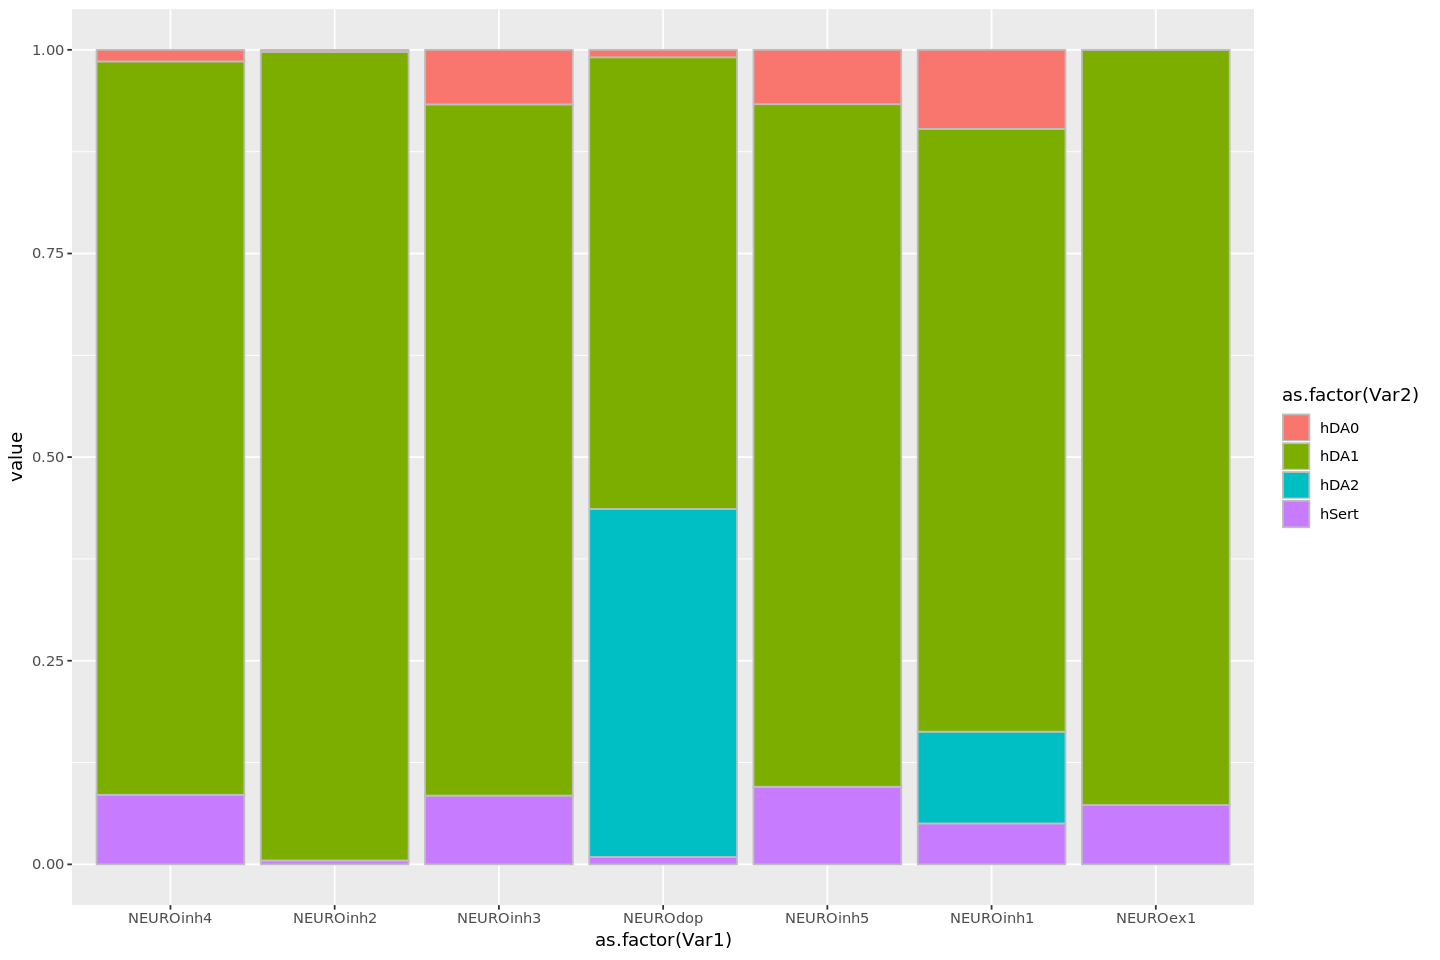

In [47]:
df = as.data.frame(mat_melt)
options(repr.plot.width=12, repr.plot.height=8)
ggplot(df, aes(x = as.factor(Var1), y = value, fill = as.factor(Var2))) + geom_bar(stat="identity", col = "grey")